# Logistic Regression

In this lab, you will implement logistic regression and apply it to two different datasets.

## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline

## 1 -  Problem Statement
Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, you have the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

## 2 - Dataset
- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision 
      - `y_train = 1` if the student was admitted 
      - `y_train = 0` if the student was not admitted 
  - Both `X_train` and `y_train` are numpy arrays.


In [2]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

In [3]:
# load dataset
X_train, y_train = load_data("data/applicant.txt")

## 3 -  Visualize data

It is often useful to understand the data by visualizing it. 
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.


In [4]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)

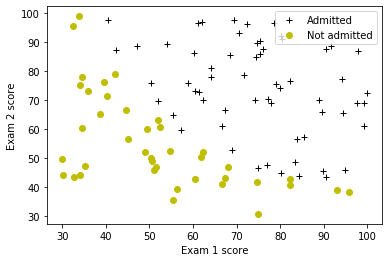

In [5]:
# Plot 
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

plt.ylabel('Exam 2 score') 
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")
plt.show()

## 4 - Sigmoid function

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.


In [6]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
   
    g = 1 / (1 + np.exp(-z))
      
    return g

## 5 - Cost function for logistic regression

Implement the cost function for logistic regression.

The cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

In [7]:
#  compute_cost
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    loss_sum = 0 
    for i in range(m):
        z_wb = b
        for j in range(n):
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij
        f_wb = sigmoid(z_wb)
        loss = (-y[i] * np.log(f_wb)) - ((1 - y[i]) * np.log(1 - f_wb))
        loss_sum += loss
    total_cost = (1 / m) * loss_sum 

    return total_cost

In [8]:
# Compute and display cost with non-zero w
test_w = np.array([0.2, 0.2])
test_b = -24.
cost = compute_cost(X_train, y_train, test_w, test_b)

print('Cost at test w,b: {:.3f}'.format(cost))

Cost at test w,b: 0.218


## 6 - Gradient for logistic regression

Implement the gradient for logistic regression.

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

complete the `compute_gradient` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

In [9]:
# compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = b
        for j in range(n):
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij
        f_wb = sigmoid(z_wb)
        
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        
        for j in range(n):
            dj_dw_ij = (f_wb - y[i])* X[i][j]
            dj_dw[j] += dj_dw_ij
            
    dj_dw = dj_dw / m
    dj_db = dj_db / m
        
    return dj_db, dj_dw

In [10]:
# Compute and display gradient with w initialized to zeroes
n =  X_train.shape[1]
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.00921658929115, -11.262842205513591]


## 7 - Learning parameters using gradient descent 

Now find the optimal parameters of a logistic regression model by using gradient descent. 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

In [11]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        if i<100000:
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history

Now run the gradient descent algorithm above to learn the parameters for our dataset.

In [12]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


## 7 - Plotting the decision boundary

Now use the final parameters from gradient descent to plot the linear fit.

In [13]:
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_data(X[:, 0:2], y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0.5
        plt.contour(u,v,z, levels = [0.5], colors="g")


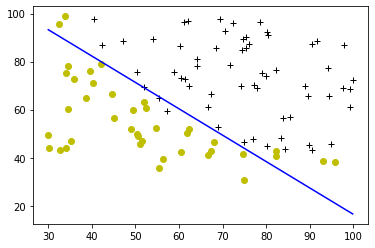

In [14]:
plot_decision_boundary(w, b, X_train, y_train)

## 8 - Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

The `predict` function produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example 
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [15]:
# predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    m, n = X.shape   
    p = np.zeros(m)
   
    for i in range(m):   
        # Add bias term 
        z_wb = b
        for j in range(n): 
            z_wb_ij = X[i, j] * w[j]
            z_wb += z_wb_ij

        f_wb = sigmoid(z_wb)
        p[i] = f_wb >= 0.5
        
    return p

Now use this to compute the accuracy on the training set

In [16]:
# Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000
